<a href="https://colab.research.google.com/github/abrown9008/STAT-7110-Quality-Control/blob/main/Slides/Class2/STAT_7110_Class_2_Python_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT 7110 Class 2: Introduction to Shewhart $\bar{X}$ and $R$ Charts

Let's perform a Phase I monitoring analysis of the Wafer Data.  
First, we have to upload the data before we can read it in using `pandas`:

## Reading in the Data

In [2]:
## Upload Data to Google Colab ##
from google.colab import files
uploaded = files.upload()

Saving Wafer Data.xlsx to Wafer Data.xlsx


In [3]:
## Import Data Using pandas ##
import pandas as pd
flow = pd.read_excel('Wafer Data.xlsx')
flow.head()

,Sample Number,Wafer 1,Wafer 2,Wafer 3,Wafer 4,Wafer 5
0,1,1.3235,1.4128,1.6744,1.4573,1.6914
1,2,1.4314,1.3592,1.6075,1.4666,1.6109
2,3,1.4284,1.4871,1.4932,1.4324,1.5674
3,4,1.5028,1.6352,1.3841,1.2831,1.5507
4,5,1.5604,1.2735,1.5265,1.4363,1.6441


## Setting Up Phase I $\bar{X}$ and $R$ Charts using `matplotlib` and `numpy`

Notice that these data are organized in a "wide format" meaning that each row represents a point in time rather than a unique observation.

Now, let's go ahead and set up our Phase I control charts using the packages `matplotlib` and `numpy`:

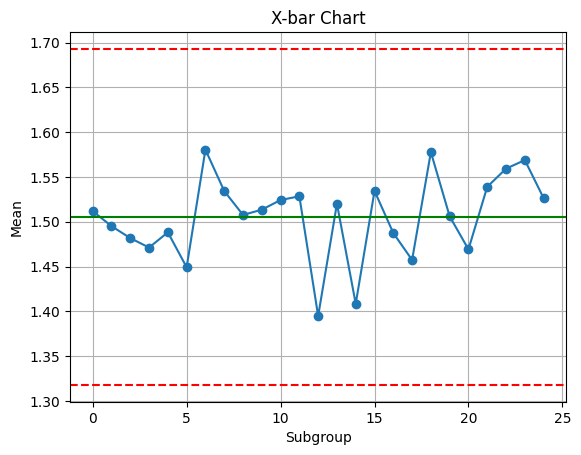

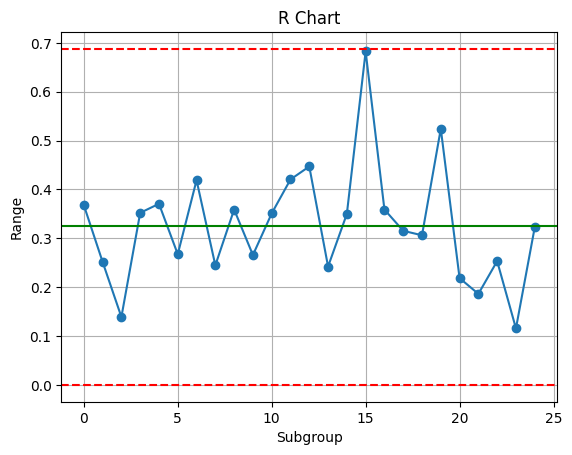

In [4]:
## Create a Phase I X-bar Chart ##
import numpy as np
import matplotlib.pyplot as plt

## Specify Control Charting Constants ##

d2 = 2.326
D3 = 0
D4 = 2.114
L = 3
n = 5

## Now, let's calculate X-double bar and R-bar for
## our overall estimates of the mean and standard deviation ##

xdbar = np.mean(flow.drop(columns=['Sample Number']))
rbar = np.mean(np.ptp(flow.drop(columns=['Sample Number']),axis=1))

## We can now calculate the control limits for the X-bar
## and R Charts: ##

UCLx = xdbar + L/(d2*np.sqrt(n))*rbar
LCLx = xdbar - L/(d2*np.sqrt(n))*rbar

UCLr = D4*rbar
LCLr = D3*rbar

## Let's calculate the group means and group ranges: ##

means = np.mean(flow.drop(columns=['Sample Number']),axis=1)
ranges = np.ptp(flow.drop(columns=['Sample Number']),axis=1)

## Finally, we can generate a control chart
## using matplotlib ##

## X-Bar ##

plt.plot(means, marker='o', linestyle='-')
plt.axhline(UCLx, color='r', linestyle='--')
plt.axhline(xdbar, color='g', linestyle='-')
plt.axhline(LCLx, color='r', linestyle='--')
plt.title('X-bar Chart')
plt.xlabel('Subgroup')
plt.ylabel('Mean')
plt.grid(True)
plt.show()

## R-Chart ##

plt.plot(ranges, marker='o', linestyle='-')
plt.axhline(UCLr, color='r', linestyle='--', label='UCL')
plt.axhline(rbar, color='g', linestyle='-', label='CL')
plt.axhline(LCLr, color='r', linestyle='--', label='LCL')
plt.title('R Chart')
plt.xlabel('Subgroup')
plt.ylabel('Range')
plt.grid(True)
plt.show()

Notice, because all the points in both graphs fall within their respective control limits, this indicates to us that our estimated mean and standard devation seem adequate. Thus, from our sample Phase I data, we can say that we have evidence of *statistical control*.  

Recall, establishing statistical control is only one piece of Phase I analysis. The second part requires the evaluation of process capability. A process is considered capable when it consistently meets the requirements of the end-user. To quantify this, we have a few different measures available to us, including $\hat{C}_p$ and the fraction non-conforming. Let's see how we can calculate these measures using Python:

In [5]:
## Calculating Cp ##

USL = 2
LSL = 1
sigma = rbar/d2
Cp = (USL - LSL)/(6*sigma)
print(Cp)

## Calculating FNC ##

#!pip install scipy.stats
from scipy.stats import norm
FNC = 1 - (norm.cdf(USL,loc=xdbar,scale=sigma) - norm.cdf(LSL,loc=xdbar,scale=sigma))
print(FNC)

1.1920575959590993
0.0003521822196048685


From the above output, we can see that $\hat{C}_p = 1.192$ and $FNC = 0.00035$. This suggests that the specification interval is 1.192 times the length of the natural tolerance band thus indicating a capable process. The FNC value suggests that for every 100,000 samples, we would expect to produce only 25 defective units (which is good!).

Let's see if we can generate a similar plot to what we saw with R to visualize process capability:

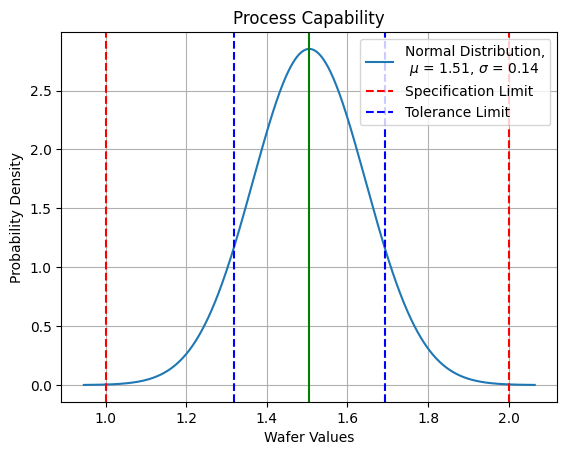

In [6]:
## Using matplotlib to visualize process capability ##

## Create a range of x-values ##

x = np.linspace(xdbar - 4*sigma,
                xdbar + 4*sigma,
                1000)

## Calculate Corresponding y-values using PDF ##

y = norm.pdf(x,loc=xdbar,scale=sigma)

## Plot the PDF ##

plt.plot(x,y,
         label = f'Normal Distribution,\n $\mu$ = {xdbar:.2f}, $\sigma$ = {sigma:.2f}')

## Add Vertical Lines Representing the Specification Limits & Center Line ##

plt.axvline(USL,color='r',linestyle='--',label='Specification Limit')
plt.axvline(xdbar,color='g',linestyle='-')
plt.axvline(LSL,color='r',linestyle='--')

## Add Vertical Lines Representing the Tolerance Limits ##

plt.axvline(LCLx,color='b',linestyle='--',label='Tolerance Limit')
plt.axvline(UCLx,color='b',linestyle='--')

plt.title('Process Capability')
plt.xlabel('Wafer Values')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

## OC-Curves

Just like we were able to do in R, we can also create Operating Characteristic Curves using `matplotlib` to visualize the changes in probability of observing an out-of-control point given various sample sizes. Here, we can do it manually to observe the statistical logic underpinning the visualization:

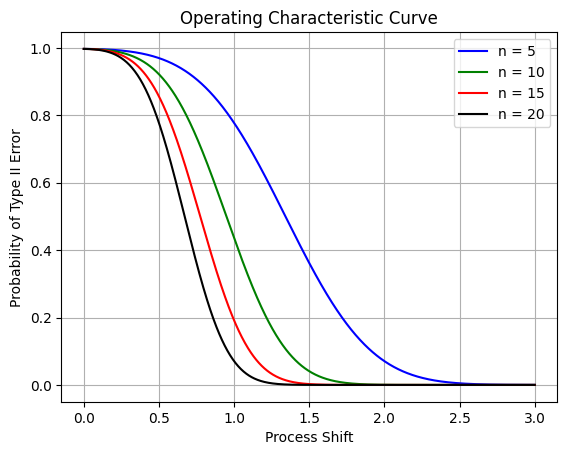

In [40]:
## Create an OC-Curve for the Shewhart X-bar Chart ##

## Create a vector containing alternative means
## shifting from 0 to 3 standard deviations ##

process_shift = np.linspace(0,3,1000)

## Let's specify a vector of n's (n = 5, 10, 15, 20) ##

n_vec = [5,10,15,20]

## Given that beta = Phi(L - k*sqrt(n)) - Phi(-L - k*sqrt(n))
## where Phi is the CDF of the Standard Normal Distribution,
## we can calculate our betas directly. Let's define
## a function to do so: ##

def beta(L,n,k):
  return norm.cdf(L - k*np.sqrt(n)) - norm.cdf(-L - k*np.sqrt(n))

## Now let's create a matrix looping through the combinations of k and n_vec ##

betas = np.zeros((len(process_shift),len(n_vec)))

for i in range(len(process_shift)):
  for j in range(len(n_vec)):
    betas[i,j] = beta(L,n_vec[j],process_shift[i])

## Convert the array to a pandas dataframe ##

betasdf = pd.DataFrame(betas,columns=[str(n) for n in n_vec])
betasdf.head()

## Plot the OC-Curves ##

plt.plot(process_shift,betasdf[["5"]],label='n = 5',color='blue')
plt.plot(process_shift,betasdf[['10']],label='n = 10',color='green')
plt.plot(process_shift,betasdf[['15']],label='n = 15',color='red')
plt.plot(process_shift,betasdf[['20']],label='n = 20',color='black')
plt.title('Operating Characteristic Curve')
plt.xlabel('Process Shift')
plt.ylabel('Probability of Type II Error')
plt.legend()
plt.grid(True)
plt.show()